In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk

import requests
import networkx as nx
import os
import re
import pickle
from bs4 import BeautifulSoup
from itertools import combinations
from requests.exceptions import HTTPError, MissingSchema

from sklearn.linear_model import Ridge
from sklearn.model_selection import ShuffleSplit

import scipy.sparse as sp
from sklearn.feature_extraction.text import CountVectorizer

# Исследование отзывов на супы быстрого приготовления
Источником данных для этой работы послужил рейтинг с сайта [The Ramen Rater](https://www.theramenrater.com/resources-2/the-list/), содержащий более 3500 отзывов на супы рамен в разных формах. Каждому отзыву соответствует рейтинг по пятибалльной шкале, указана страна изготовления, стиль приготовления блюда, бренд и название товара.

In [2]:
URL = "https://www.theramenrater.com/resources-2/the-list/"

In [6]:
if os.path.exists('ramen_reviews.json'):
    review_df = pd.read_json('ramen_reviews.json')
    print("Скачивание датасета уже производилось, переходи к обработке")

Скачивание датасета уже производилось, переходи к обработке


## Извлечение данных
К сожалению авторы датасета изменили структуру поставки данных и нет теперь большой таблицы со ссылками на все обзоры. К этому документу прилагается файл `ramen_reviews.json`, который был создан во время парсинга сайта и обработка информации в разделе [обработка](#process) будет производиться с его использованием.

In [4]:
# Достаём список ссылок
resp = requests.get(URL)
soup = BeautifulSoup(resp.content, 'html.parser')
links_taglist = soup.select("#myTable a")
links_list = []
for link_tag in links_taglist:
    link = link_tag['href']
    links_list.append(link)

Получим все отзывы, какие удастся.

In [5]:
session = requests.Session()
paragraphs_list = []
for link in links_list:
    try:
        resp = session.get(link)
        # print("Обрабатываю: {}".format(link))
        soup = BeautifulSoup(resp.content, 'html.parser')
        title = soup.select('.entry-title')
        paragraphs = soup.select('.entry-content > p')
        paragraphs_list.append({'title': title,
                                'paragraphs': paragraphs})
    except (HTTPError, MissingSchema):
        print("Ошибка обработки URL")
        continue
print("Успешно закончили!")

Успешно закончили!


In [6]:
print("Получили текстов отзывов: {}".format(len(paragraphs_list)))

Получили текстов отзывов: 0


Напишем функцию, которая из указанных текстов будет извлекать тексты абзацев с итоговым впечатлениям, по которому можно будет составить представление о настроении отзыва.

In [36]:
def get_sentiment_relevant_text(review_dict):
    """Достать из списка тэгов кусочек текста, который имеет отношение к 
    настроению отзыва.
    Аргументы:
        tag_list (list) - список тэгов, из которых нужно вытащить текст.
    Возвращает:
        output (dict) - Словарь содержимого отзыва: номер отзыва, текст отзыва,
            код и тип кода.
    """
    num_text = review_dict['title'][0].get_text()
    try:
        num_review = re.search("\d+", num_text).group(0)
    except AttributeError:
        return
    text_list = [tag.get_text() for tag in review_dict['paragraphs']]
    text_list = [text for text in text_list if 'Finished' in text]
    
    if text_list:
        pattern = re.compile("(Finished.*?\.)(.*)")
        review_groups = re.match(pattern, text_list[0])
        try:
            review = review_groups.group(2).strip()
        except AttributeError:
            return
        return {'Review #': num_review,
                'Review Content': review}

In [44]:
review_texts_list = list(map(get_sentiment_relevant_text, paragraphs_list))
review_texts_list = [i for i in review_texts_list if i]

In [39]:
raw, = pd.read_html(URL, flavor='bs4', attrs={'id': 'myTable'})
raw.head()

,Review #,Brand,Variety,Style,Country,Stars,T
0,3637,Samyang Foods,3X Spicy Buldak HOT Fried Chicken,Pack,South Korea,4,NaN
1,3636,GB Company,The Devil Of Fire Ramen,Pack,South Korea,4,NaN
2,3635,Acecook,Fujicco Pure Tororo Konbu Soba,Cup,Japan,0,NaN
3,3634,Acecook,Yokosuka Navy Curry,Cup,Japan,3.5,NaN
4,3633,Sau Tao,Laksa Flavour Ramen,Pack,Hong Kong,5,NaN


In [50]:
review_content_df = pd.DataFrame(review_texts_list)
review_content_df.head()

,Review #,Review Content
0,3637,Noodles are big and thick and very nice. This ...
1,3636,Added nothing as it was for a mukbang. The noo...
2,3635,Added spring onion. Where do I start. The nood...
3,3634,"Added shichimi, La-Yu chilli oil, kamaboko, Sa..."
4,3633,"Added spring onion, Salad Cosmo mung bean spro..."


In [59]:
review_df = raw.merge(review_content_df, on='Review #', how='inner')
review_df = review_df.drop('T', axis=1)
review_df['Review #'] = review_df['Review #'].astype(np.int32)
review_df.head()

,Review #,Brand,Variety,Style,Country,Stars,Review Content
0,3637,Samyang Foods,3X Spicy Buldak HOT Fried Chicken,Pack,South Korea,4,Noodles are big and thick and very nice. This ...
1,3636,GB Company,The Devil Of Fire Ramen,Pack,South Korea,4,Added nothing as it was for a mukbang. The noo...
2,3635,Acecook,Fujicco Pure Tororo Konbu Soba,Cup,Japan,0,Added spring onion. Where do I start. The nood...
3,3634,Acecook,Yokosuka Navy Curry,Cup,Japan,3.5,"Added shichimi, La-Yu chilli oil, kamaboko, Sa..."
4,3633,Sau Tao,Laksa Flavour Ramen,Pack,Hong Kong,5,"Added spring onion, Salad Cosmo mung bean spro..."


Сохраним получившиеся данные в файл

In [60]:
review_dict = review_df.to_dict()
with open('ramen_reviews.json', 'w') as f:
    json.dump(review_dict, f)

## <span id="process">Обработка</span>

In [7]:
top_20_brands = review_df['Brand'].value_counts()[:20].index.to_list()
top_4_styles = review_df['Style'].value_counts()[:4].index.to_list()
top_12_countries = review_df['Country'].value_counts()[:12].index.to_list()

In [8]:
lumped_df = review_df.copy()
lumped_df['Stars'] = pd.to_numeric(lumped_df['Stars'], errors='coerce')
lumped_df['Brand'] = [i if i in top_20_brands else 'Other' for i in lumped_df['Brand']]
lumped_df['Style'] = [i if i in top_4_styles else 'Other' for i in lumped_df['Style']]
lumped_df['Country'] = [i if i in top_12_countries else 'Other' for i in lumped_df['Country']]
lumped_df = lumped_df.dropna()

In [9]:
long_df = pd.melt(lumped_df.loc[:,'Brand':'Country'], var_name='category')
group_counts = long_df.groupby(['category', 'value']).size()
group_counts = group_counts.groupby(level=0, group_keys=False).nlargest(16)

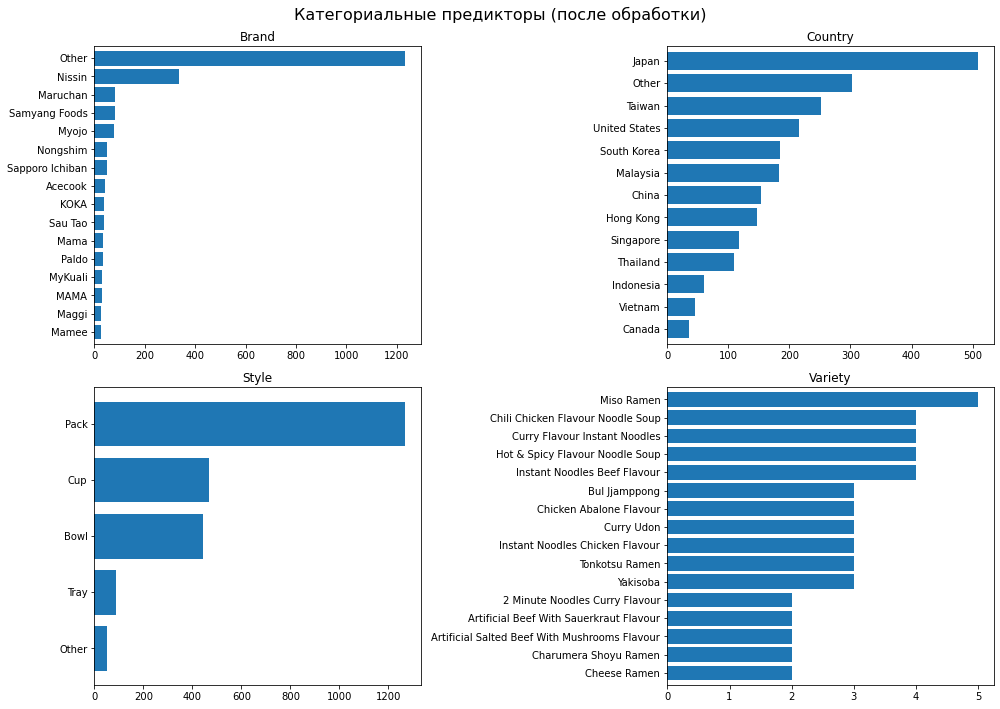

In [10]:
fig, ax = plt.subplots(2, 2)
ax = ax.reshape(-1)
fig.set_size_inches((14, 10))
fig.suptitle('Категориальные предикторы (после обработки)', size=16)
for i, category in enumerate(group_counts.index.levels[0]):
    group_counts[category].plot(kind='barh', ax=ax[i], width=0.8)
    ax[i].invert_yaxis()
    ax[i].set_ylabel('')
    ax[i].set_title(category)
fig.tight_layout()

In [11]:
model_df = pd.get_dummies(lumped_df.loc[:,['Brand','Country','Style']])
model_df.insert(0, 'Stars', lumped_df['Stars'])
model_df = model_df.reset_index(drop=True)

In [12]:
ss = ShuffleSplit(n_splits=20, train_size=0.9)
linmodel = Ridge()

coefs = []
intercept = []
for train_split, test_split in ss.split(model_df.iloc[:, 1:], model_df.iloc[:, 0]):
    linmodel.fit(model_df.iloc[train_split, 1:], model_df.iloc[train_split, 0])
    coefs.append(linmodel.coef_)
    intercept.append(linmodel.intercept_)

coefs_arr = np.array(coefs)
means = coefs_arr.mean(axis=0)
stds = coefs_arr.std(axis=0)

intercept_arr = np.array(intercept)
intercept = intercept_arr.mean()
intercept_std = intercept_arr.std()

In [13]:
features = model_df.columns[1:].to_list()
coefs_df = pd.DataFrame({'Признак': features,
                         'Коэффициент': means,
                         'Стандартное отклонение': stds,
                         'error': 2 * stds})
coefs_df = coefs_df.sort_values(by='Коэффициент', ascending=False)
coefs_df = coefs_df.reset_index(drop=True)
coefs_df[['Категория', 'Признак']] = coefs_df['Признак'].str.split("_", expand=True)

In [14]:
print("Базовый уровень: {0:.3f}±{1:.3f}".format(intercept, 2*intercept_std))

Базовый уровень: 3.861±0.037


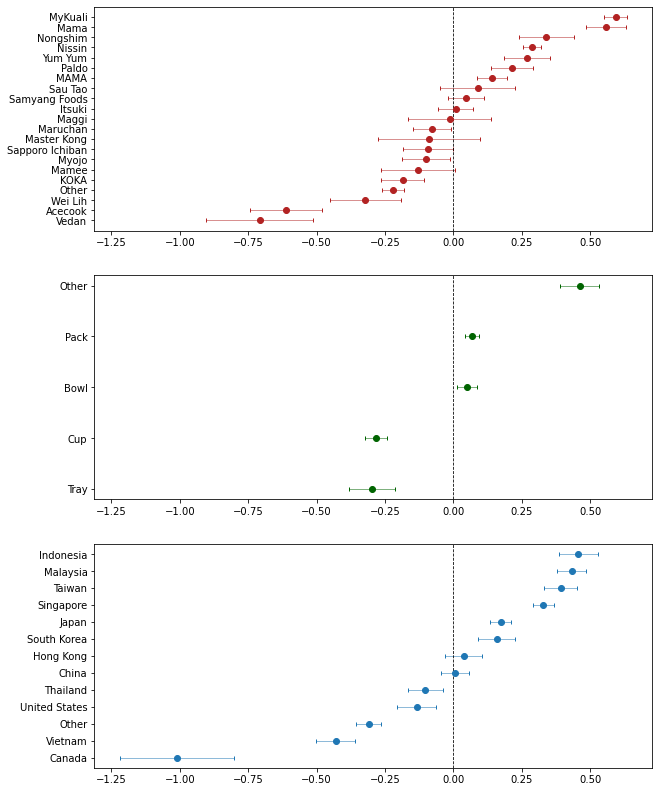

In [15]:
colors = ['firebrick', 'darkgreen', 'C0']
fig, ax = plt.subplots(3, 1, sharex=True)
fig.set_size_inches((10, 14))
for i, category in enumerate(coefs_df['Категория'].unique()):
    plot_data = coefs_df.loc[coefs_df['Категория'] == category, :].sort_values("Коэффициент")
    ax[i].errorbar(plot_data.loc[:, "Коэффициент"], plot_data.loc[:, "Признак"], 
                   xerr=plot_data.loc[:, "error"], marker='o', ls='', elinewidth=0.5,
                  capsize=2, color=colors[i])    
    ax[i].axvline(color="k", ls='--', lw=0.8)
    ax[i].xaxis.set_tick_params(labelbottom=True)

In [16]:
review_tokens_df = review_df.copy()
stop_words = nltk.corpus.stopwords.words('english')
review_tokens_df['Review Content'] = [nltk.word_tokenize(review.lower()) 
                                      for review in review_tokens_df['Review Content']]
review_tokens_df['Review Content'] = (review_tokens_df['Review Content']
                                      .map(lambda tokens: [token for token in tokens
                                                           if re.search("[a-z]", token)
                                                           if token not in stop_words]))
review_tokens_df['Stars'] = pd.to_numeric(review_tokens_df['Stars'], errors='coerce')
review_tokens_df = review_tokens_df.dropna().reset_index(drop=True)
review_tokens_df.head()

,Review #,Brand,Variety,Style,Country,Stars,Review Content
0,3637,Samyang Foods,3X Spicy Buldak HOT Fried Chicken,Pack,South Korea,4.0,"[noodles, big, thick, nice, one, really, tasty..."
1,3636,GB Company,The Devil Of Fire Ramen,Pack,South Korea,4.0,"[added, nothing, mukbang, noodles, nice, thick..."
2,3635,Acecook,Fujicco Pure Tororo Konbu Soba,Cup,Japan,0.0,"[added, spring, onion, start, noodles, bad, fa..."
3,3634,Acecook,Yokosuka Navy Curry,Cup,Japan,3.5,"[added, shichimi, la-yu, chilli, oil, kamaboko..."
4,3633,Sau Tao,Laksa Flavour Ramen,Pack,Hong Kong,5.0,"[added, spring, onion, salad, cosmo, mung, bea..."


In [17]:
review_tokens_df_exploded = review_tokens_df.explode('Review Content')
review_tokens_df_exploded = review_tokens_df_exploded.rename(columns={'Review Content': 'Word'})
review_tokens_df_exploded.head()

,Review #,Brand,Variety,Style,Country,Stars,Word
0,3637,Samyang Foods,3X Spicy Buldak HOT Fried Chicken,Pack,South Korea,4.0,noodles
0,3637,Samyang Foods,3X Spicy Buldak HOT Fried Chicken,Pack,South Korea,4.0,big
0,3637,Samyang Foods,3X Spicy Buldak HOT Fried Chicken,Pack,South Korea,4.0,thick
0,3637,Samyang Foods,3X Spicy Buldak HOT Fried Chicken,Pack,South Korea,4.0,nice
0,3637,Samyang Foods,3X Spicy Buldak HOT Fried Chicken,Pack,South Korea,4.0,one


In [16]:
review_words = (review_tokens_df_exploded.groupby('Word', as_index=False)
                .agg({'Review #': 'count', 'Brand': 'nunique', 'Stars': 'mean'})
                .sort_values('Review #', ascending=False)
                .rename(columns={'Review #': 'n', 'Brand': 'n_distinct', 'Stars': 'avg_rating'}))

In [17]:
# слова часто употребимые с одной стороны, но и не повсеместные
review_words_filtered = review_words.loc[(review_words['n_distinct'] <= 400) &
                                         (review_words['n_distinct'] >= 20),:]
review_words_filtered = review_words_filtered.reset_index(drop=True)
review_words_filtered

,Word,n,n_distinct,avg_rating
0,noodles,2351,396,3.849957
1,added,2053,388,3.882611
2,broth,1864,327,3.857430
3,nice,1705,296,4.104106
4,onion,1566,318,3.901820
...,...,...,...,...
398,definite,22,20,3.647727
399,peppery,22,20,4.000000
400,average,22,20,4.147727
401,crispy,21,20,3.904762


In [19]:
vectorizer = CountVectorizer(stop_words=stop_words, tokenizer=nltk.word_tokenize)
term_doc_matrix = vectorizer.fit_transform(review_df['Review Content'])
indices = [vectorizer.vocabulary_[word] for word in review_words_filtered['Word']]
cooc_matrix = (term_doc_matrix.T * term_doc_matrix)
cooc_matrix = cooc_matrix / cooc_matrix.diagonal()
cooc_arr = np.array(cooc_matrix)
cooc_arr = cooc_arr[indices]
cooc_arr = cooc_arr[:, indices]
cooc_df = pd.DataFrame(cooc_arr, index=review_words_filtered['Word'], columns=review_words_filtered['Word'])

In [20]:
word_pairs = pd.DataFrame(combinations(review_words_filtered['Word'],2))
word_pairs = word_pairs.rename(columns={0: 'WordA', 1: 'WordB'})
word_pairs['Occurence'] = [cooc_df.loc[j, i] for i, j in zip(word_pairs['WordA'], word_pairs['WordB'])]
word_pairs = word_pairs.merge(review_words_filtered, left_on='WordA', right_on='Word')
word_pairs = word_pairs[['WordA', 'WordB', 'Occurence', 'avg_rating']]
word_pairs = word_pairs.sort_values('Occurence', ascending=False)
word_pairs = word_pairs.iloc[:300].reset_index(drop=True)
word_pairs

,WordA,WordB,Occurence,avg_rating
0,cosmo,salad,0.996970,3.947597
1,mung,sprouts,0.982175,3.929955
2,pok,tau,0.960526,4.246479
3,bean,mung,0.959829,3.941871
4,bean,sprouts,0.947863,3.941871
...,...,...,...,...
295,pork,jan,0.244361,4.100592
296,salad,coriander,0.243680,3.940635
297,cosmo,coriander,0.243434,3.947597
298,noodles,chew,0.243315,3.849957


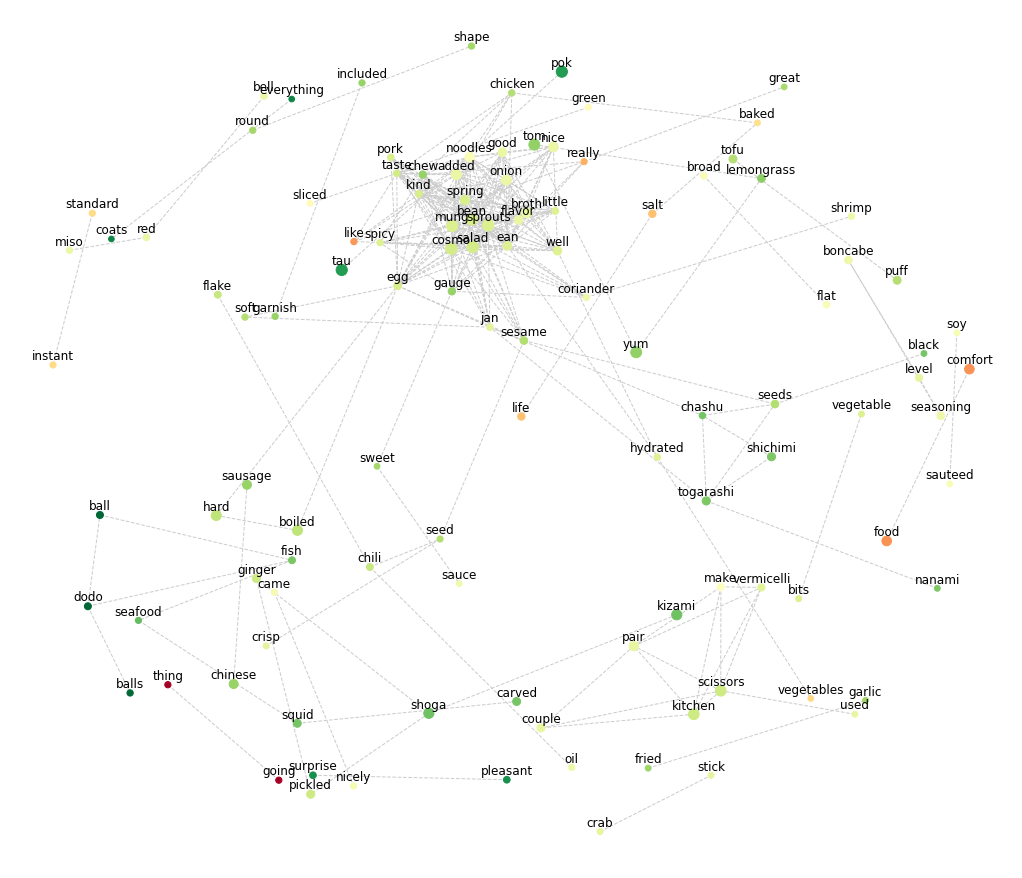

In [21]:
graph = nx.from_pandas_edgelist(word_pairs, source='WordA', target='WordB', 
                                edge_attr=['Occurence', 'avg_rating'])
color_code = []
node_size = []
for node in graph:
    for _, x in word_pairs.iterrows():
        if x.WordA == node:
            color_code.append(x.avg_rating)
            node_size.append(x.Occurence*130)
            break
        elif x.WordB == node:
            color_code.append(x.avg_rating)
            node_size.append(x.Occurence*130)
            break
        else:
            continue

plt.figure(figsize=(14,12))
pos = nx.spring_layout(graph, k=0.5)
nx.draw(graph, pos, node_color=color_code, node_size=node_size, cmap=plt.cm.RdYlGn, width=1,
       style='dashed', edge_color='0.8')
for p in pos:  # raise text positions
    pos[p][1] += 0.02
nx.draw_networkx_labels(graph, pos)
plt.show()